# Applications

* Clustering: **Gaussian mixture models** (GMM)
* Dimensionality reduction: **principal component analysis** (PCA)
* Dimensionality reduction: **Pearson product-moment correlation coefficient**
* Optimization/Neuroevolution: **covariance matrix adaption evolution strategies** (CMA-ES)
* State estimation: **Kalman filter**

In [1]:
%pylab inline
set_printoptions(precision=4, suppress=True)

Populating the interactive namespace from numpy and matplotlib


# Normal Distribution in 1D

In [2]:
def gaussian_pdf_1d(x, mean, variance):
    return 1.0 / sqrt(2*pi*variance) * exp(-0.5*(x-mean)**2 / variance)

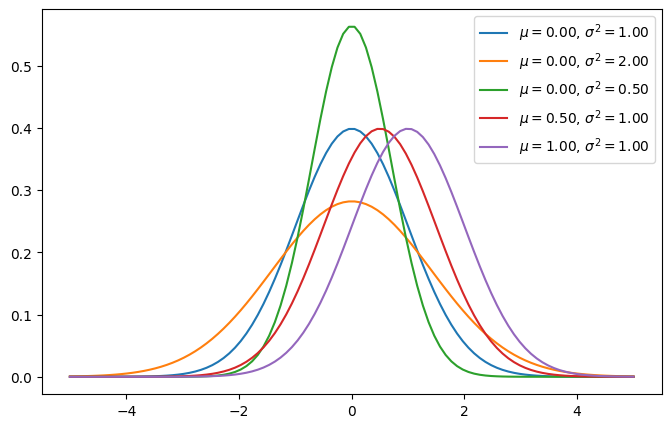

In [3]:
figure(figsize=(8, 5))
x = linspace(-5, 5, 100)
for mu, sigma in [(0.0, 1.0), (0.0, 2.0), (0.0, 0.5), (0.5, 1.0), (1.0, 1.0)]:
    plot(x, gaussian_pdf_1d(x, mu, sigma), label="$\mu=%.2f$, $\sigma^2=%.2f$" % (mu, sigma))
legend(loc="best")

Mean
----

$$\mu = E(X)$$

* $X$ is a random variable

Variance
--------

$$V(X) = E([X-\mu]^2) = \sigma_X^2$$

# Normal Distribution in 2D

In [4]:
def gaussian_pdf(x, x_mean, x_covariance):
    d = x.shape[-1]
    diff = x - x_mean
    return 1.0 / sqrt((2*pi)**d * linalg.det(x_covariance)) * exp(-0.5*diff.dot(linalg.inv(x_covariance)).dot(diff))

In [5]:
def generate_plot_data(x_mean, x_covariance):
    xx, yy = meshgrid(linspace(-3, 3, 100), linspace(-3, 3, 100))
    zz = zeros_like(xx)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            zz[i, j] = gaussian_pdf(array([xx[i, j], yy[i, j]]), x_mean, x_covariance)
    return xx, yy, zz

In [6]:
xx, yy, zz = generate_plot_data(zeros(2), eye(2))

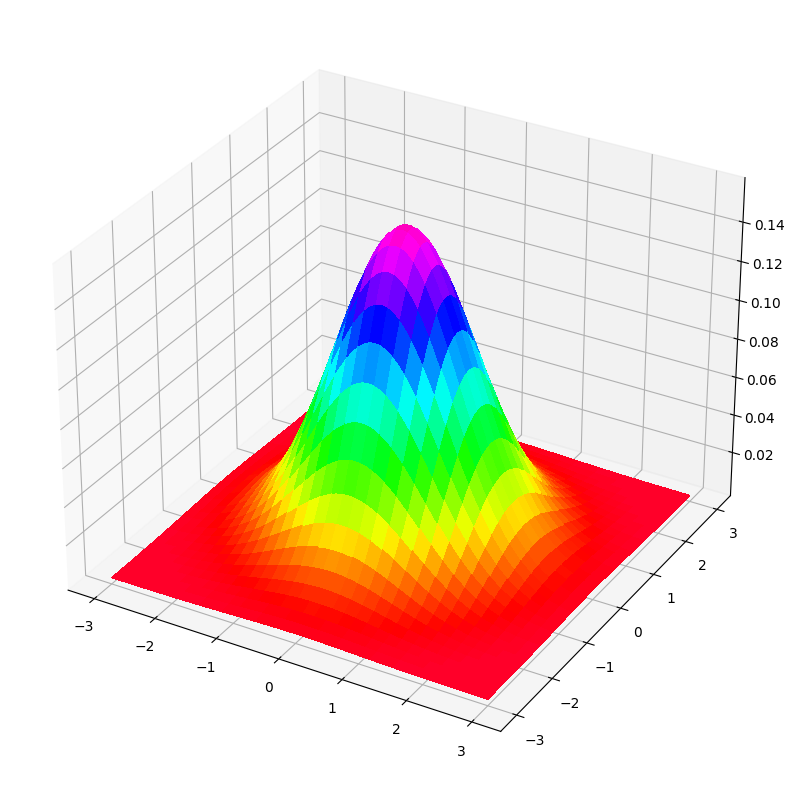

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig = figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(xx, yy, zz, rstride=3, cstride=3, cmap=cm.gist_rainbow, linewidth=0, antialiased=False)

Covariance
---------

$$\boldsymbol{\Sigma} = Cov(X) = E([X-\mu][X-\mu]^T) \in \mathbb{R}^{n \times n}$$

Example in 2D
------------
$$\boldsymbol{\Sigma} =
\begin{bmatrix}
\sigma_X^2                  & \rho_{XY} \sigma_X \sigma_Y\\\\
\rho_{XY} \sigma_X \sigma_Y & \sigma_Y^2
\end{bmatrix}$$

* $\sigma_X$: standard deviation of $X$
* $\sigma_Y$: standard deviation of $Y$
* $-1 \leq \rho_{XY} \leq 1$: correlation coefficient

## Plotting Covariance Matrices in 2D

In [8]:
def equiprobable_ellipse(C, factor=1.0):
    """Source: http://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals"""
    def eigsorted(C):
        vals, vecs = linalg.eigh(C)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    vals, vecs = eigsorted(C)
    angle = arctan2(*vecs[:,0][::-1])
    # Width and height are "full" widths, not radius
    width, height = 2 * factor * np.sqrt(vals)

    return angle, width, height

In [9]:
def plot_ellipse(C, x_range=(-3, 3), y_range=(-3, 3)):
    from matplotlib.patches import Ellipse
    for factor in linspace(0.25, 2.0, 8):
        angle, width, height = equiprobable_ellipse(C, factor)
        e = Ellipse(xy=zeros(2), width=width, height=height, angle=degrees(angle))
        e.set_alpha(0.25)
        gca().add_artist(e)
    xlim(x_range)
    ylim(y_range)

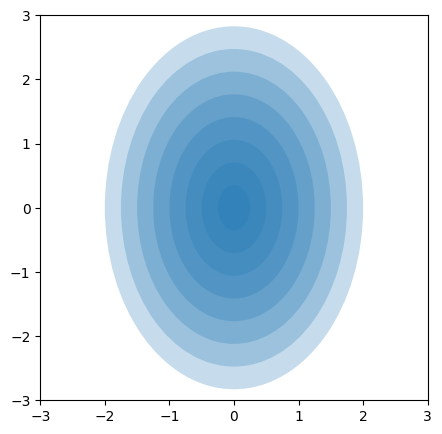

In [10]:
figure(figsize=(5, 5))
plot_ellipse(array([[1, 0], [0, 2]]))

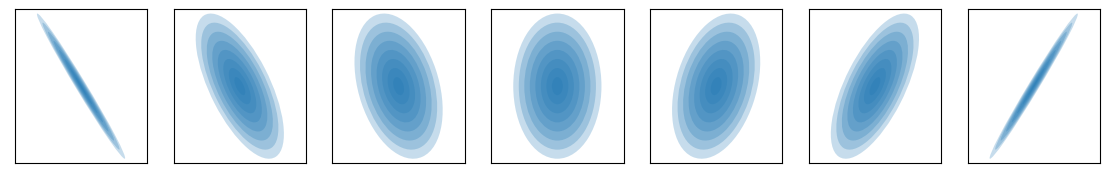

In [11]:
figure(figsize=(14, 2))
for i, rho in enumerate(linspace(-1+0.01, 1-0.01, 7)):
    subplot(1, 7, i+1)
    xticks(())
    yticks(())
    corr = 1*sqrt(2)*rho
    plot_ellipse(array([[1, corr], [corr, 2]]))

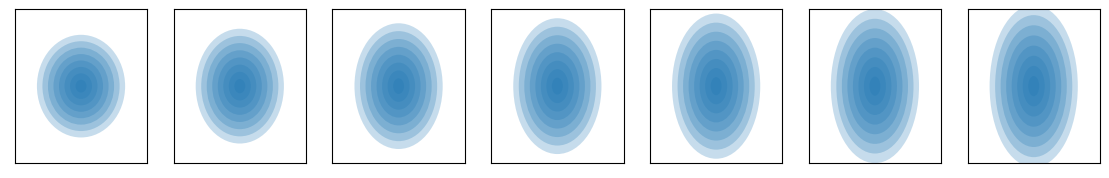

In [12]:
figure(figsize=(14, 2))
for i, var in enumerate(linspace(1, 2.5, 7)):
    subplot(1, 7, i+1)
    xticks(())
    yticks(())
    plot_ellipse(array([[1, 0], [0, var]]))

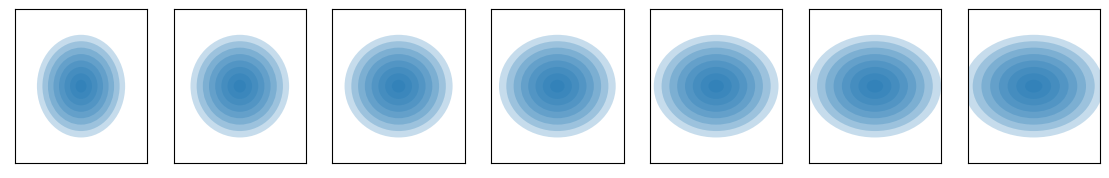

In [13]:
figure(figsize=(14, 2))
for i, var in enumerate(linspace(1, 2.5, 7)):
    subplot(1, 7, i+1)
    xticks(())
    yticks(())
    plot_ellipse(array([[var, 0], [0, 1]]))

Covariance Rotation
-----------------

$$Cov(RX) = R Cov(X) R^T$$

Here: $R \in SO(2)$ or $R \in SO(3)$ (set of rotation matrices)

In [14]:
def rotmat_2d(angle):
    return array([[cos(angle), -sin(angle)],
                   [sin(angle), cos(angle)]])

def rotcov_2d(cov, angle):
    R = rotmat_2d(angle)
    return R.dot(cov).dot(R.T)

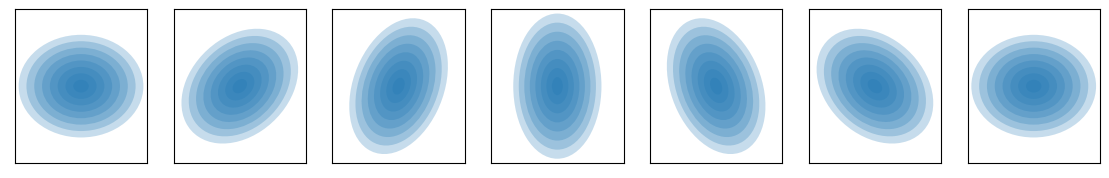

In [15]:
figure(figsize=(14, 2))
for i, angle in enumerate(linspace(-pi/2, pi/2, 7)):
    subplot(1, 7, i+1)
    xticks(())
    yticks(())
    plot_ellipse(rotcov_2d(array([[1, 0], [0, 2]]), angle))

# Sampling from Normal Distributions

**1D**

Sample numbers from uniform distribution and use [Box-Muller transform](http://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform)

In [16]:
random.randn(5)

array([ 0.1769,  1.5386, -1.1539, -1.2932,  0.961 ])

**2D**

* Compute Cholesky decomposition $L$ of $\boldsymbol{\Sigma} = LL^T$
* Draw components of a vector $z$ from 1D normal distribution
* Return $\mu + Lz$

In [17]:
def sample_multivariate_normal(mean, C):
    L = linalg.cholesky(C)
    z = random.randn(mean.shape[0])
    return mean + L.dot(z)

In [18]:
n_samples = 1000
x_mean = zeros(2)
C = array([[1.0, 1*sqrt(1.5)*0.5], [1*sqrt(1.5)*0.5, 1.5]])
X = array([sample_multivariate_normal(x_mean, C) for _ in range(n_samples)])

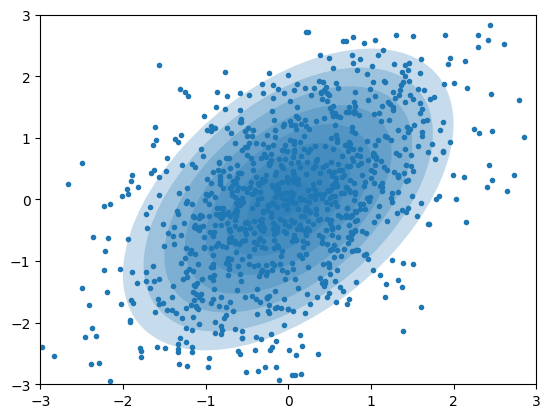

In [19]:
plot_ellipse(C)
scatter(X[:, 0], X[:, 1], marker=".")

In [20]:
random.multivariate_normal(x_mean, C)

array([-0.8189, -1.6993])

# Estimating Covariance Matrices

True distribution
----------------

$$\mathcal{N}\left(\mu, \Sigma\right)$$

In [21]:
mu = array([2, 5])
Sigma = array([[3.0, 0.5], [0.5, 2.0]])

Sampling
-------

$$\boldsymbol{X} \in \mathbb{R}^{N \times 2}, \boldsymbol{X}_i \sim \mathcal{N}(\mu, \Sigma), N = 10000$$

In [22]:
N = 10000
X = array([random.multivariate_normal(mu, Sigma) for _ in range(N)])

Empirical Mean
-------------

$$\overline{x} = \frac{1}{N} \sum_{n=1}^N x^{(n)}$$

In [23]:
x_mean = mean(X, axis=0)
x_mean

array([1.9875, 4.9699])

Empirical Covariance
------------------

If $\mu$ is known:

$$Q = \frac{1}{N} \sum_{n=1}^N (x^{(n)} - \mu)(x^{(n)} - \mu)^T$$

If $\mu$ is unknown (see [Bessel's correction](http://en.wikipedia.org/wiki/Bessel%27s_correction)):

$$Q = \frac{1}{N-1} \sum_{n=1}^N (x^{(n)} - \overline{x})(x^{(n)} - \overline{x})^T$$

In [24]:
x_cov = cov(X, rowvar=0)
x_cov

array([[2.9508, 0.4371],
       [0.4371, 1.9887]])

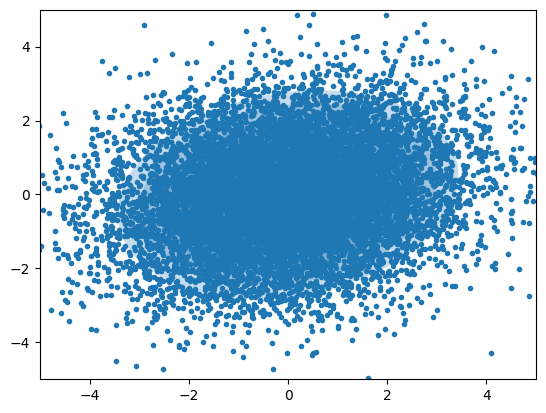

In [25]:
Xmmu = X - mu
scatter(Xmmu[:, 0], Xmmu[:, 1], marker=".")
plot_ellipse(x_cov, x_range=(-5, 5), y_range=(-5, 5))